In [3]:
# ============================================
# ANÁLISE QUANTITATIVA DA REDE TOR (TCC)
# Autor: Gabriel Dietze
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configurações visuais
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['font.size'] = 11


In [4]:
# Lista de países da aliança "Fourteen Eyes"
fourteen_eyes = ['Germany', 'Belgium', 'Canada', 'Denmark', 'Spain', 
                 'United States', 'France', 'Italy', 'Norway', 
                 'New Zealand', 'Netherlands', 'United Kingdom', 
                 'Sweden', 'Australia']
fourteen_eyes_lower = [c.lower() for c in fourteen_eyes]

# Carrega o CSV
df = pd.read_csv('circuits_enriquecido.csv')

# Limpeza: remove UNKNOWN e mantém apenas papéis válidos
df_clean = df[(df['country'] != 'UNKNOWN') &
              (df['asn'] != 'UNKNOWN') &
              (df['role'].isin(['guard', 'middle', 'exit']))].copy()

total_clean_nodes = len(df_clean)
print(f"✅ {total_clean_nodes} nós válidos após limpeza.")


✅ 652 nós válidos após limpeza.


In [5]:
# --- 1.1 Dominância de Provedores ---
asn_counts = df_clean['asn'].value_counts()
asn_percentage = (asn_counts / total_clean_nodes) * 100
asn_cumulative = asn_percentage.cumsum()

top_5_percent = asn_cumulative.iloc[4] if len(asn_cumulative) >= 5 else asn_cumulative.iloc[-1]
top_10_percent = asn_cumulative.iloc[9] if len(asn_cumulative) >= 10 else asn_cumulative.iloc[-1]

print(f"- Os 5 ASNs mais comuns controlam: {top_5_percent:.2f}% da rede.")
print(f"- Os 10 ASNs mais comuns controlam: {top_10_percent:.2f}% da rede.")


- Os 5 ASNs mais comuns controlam: 74.23% da rede.
- Os 10 ASNs mais comuns controlam: 82.52% da rede.


C:\Users\Gabri\AppData\Local\Temp\ipykernel_2708\655260021.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_20_asn.index, x=top_20_asn.values, palette="mako")


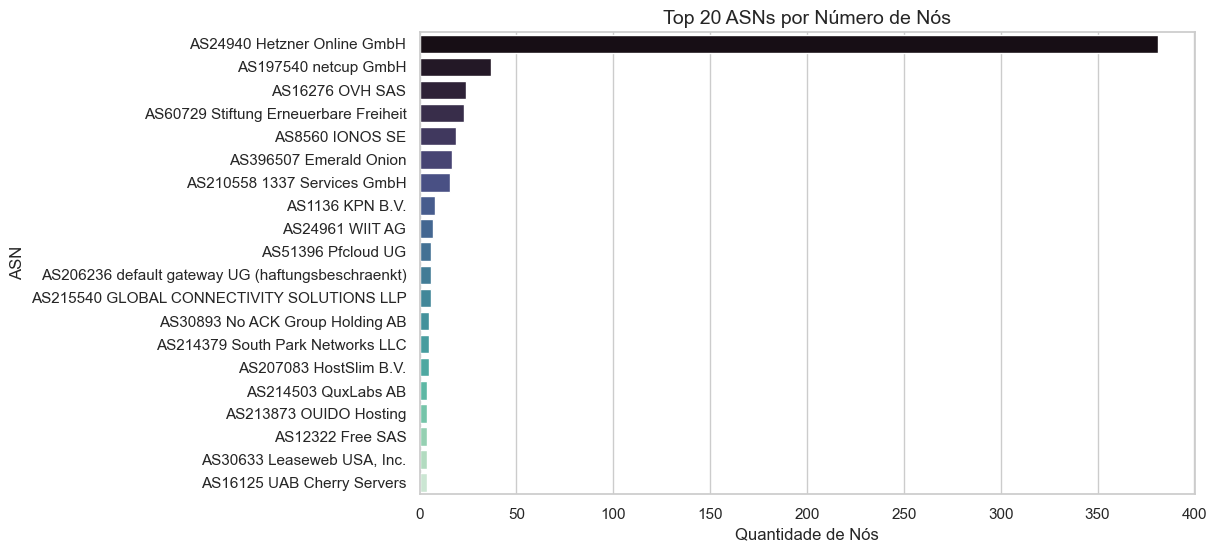

In [6]:
top_20_asn = asn_counts.head(20)
sns.barplot(y=top_20_asn.index, x=top_20_asn.values, palette="mako")
plt.title("Top 20 ASNs por Número de Nós")
plt.xlabel("Quantidade de Nós")
plt.ylabel("ASN")
plt.show()


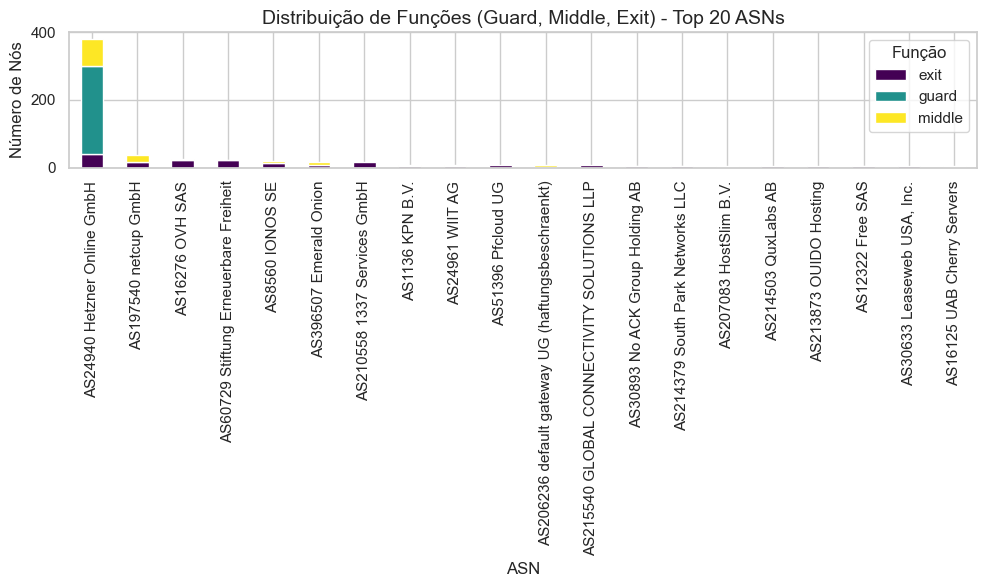

In [7]:
asn_role_distribution = df_clean.groupby(['asn', 'role']).size().unstack(fill_value=0)
top_20_asn = df_clean['asn'].value_counts().head(20).index
asn_role_top_20 = asn_role_distribution.loc[top_20_asn]

asn_role_top_20.plot(kind='bar', stacked=True, colormap='viridis')
plt.title("Distribuição de Funções (Guard, Middle, Exit) - Top 20 ASNs")
plt.xlabel("ASN")
plt.ylabel("Número de Nós")
plt.legend(title="Função")
plt.tight_layout()
plt.show()


In [8]:
# Identifica circuitos completos
circuit_groups = df_clean.groupby('circuit_id')
complete_circuit_ids = circuit_groups.filter(lambda x: len(x) == 3 and x['role'].nunique() == 3)['circuit_id'].unique()
df_circuits = df_clean[df_clean['circuit_id'].isin(complete_circuit_ids)].copy()

print(f"Total de circuitos completos analisados: {len(df_circuits)}")


Total de circuitos completos analisados: 36


In [9]:
circuits_pivot = df_circuits.pivot(index='circuit_id', columns='role', values=['country', 'asn']).reset_index()
circuits_pivot.columns = [f"{col[0]}_{col[1]}" for col in circuits_pivot.columns.values]

same_country = (circuits_pivot['country_guard'] == circuits_pivot['country_exit']).sum()
same_asn = (circuits_pivot['asn_guard'] == circuits_pivot['asn_exit']).sum()

percent_same_country = same_country / len(circuits_pivot) * 100
percent_same_asn = same_asn / len(circuits_pivot) * 100

print(f"- Guard e Exit no mesmo país: {percent_same_country:.2f}%")
print(f"- Guard e Exit no mesmo ASN: {percent_same_asn:.2f}%")


- Guard e Exit no mesmo país: 41.67%
- Guard e Exit no mesmo ASN: 8.33%


In [10]:
def in_fourteen_eyes(country):
    return country.lower() in fourteen_eyes_lower

guard_in_14eyes = circuits_pivot['country_guard'].apply(in_fourteen_eyes)
exit_in_14eyes = circuits_pivot['country_exit'].apply(in_fourteen_eyes)

jurisdictional_risk = circuits_pivot[
    (circuits_pivot['country_guard'] != circuits_pivot['country_exit']) &
    guard_in_14eyes & exit_in_14eyes
]

percent_jurisdictional_risk = len(jurisdictional_risk) / len(circuits_pivot) * 100
print(f"- Circuitos com Guard e Exit em países diferentes, mas ambos nos 14 Eyes: {percent_jurisdictional_risk:.2f}%")


- Circuitos com Guard e Exit em países diferentes, mas ambos nos 14 Eyes: 25.00%


C:\Users\Gabri\AppData\Local\Temp\ipykernel_2708\2698735760.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  circuit_paths = df_circuits.groupby('circuit_id').apply(get_circuit_path)


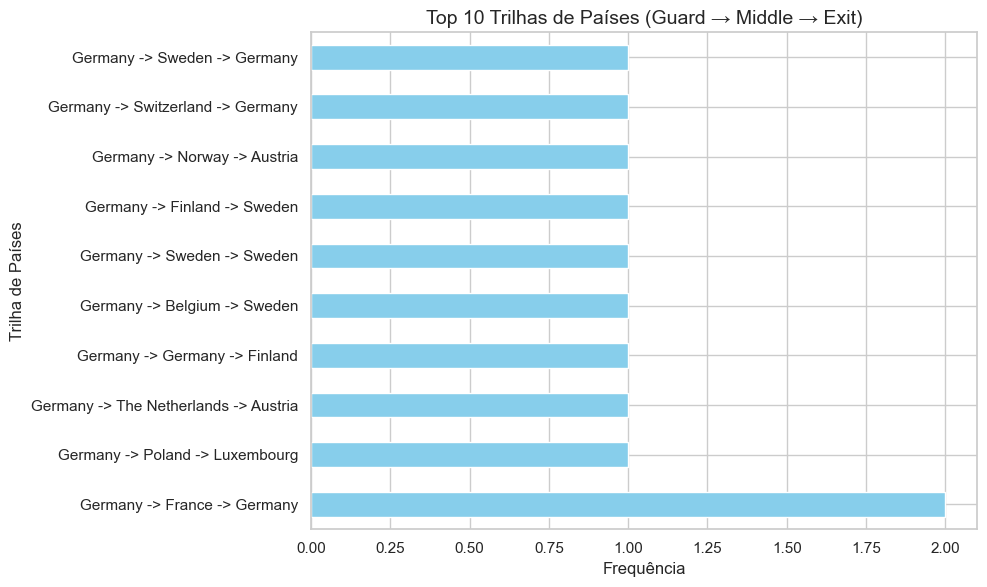

Germany -> France -> Germany             2
Germany -> Poland -> Luxembourg          1
Germany -> The Netherlands -> Austria    1
Germany -> Germany -> Finland            1
Germany -> Belgium -> Sweden             1
Germany -> Sweden -> Sweden              1
Germany -> Finland -> Sweden             1
Germany -> Norway -> Austria             1
Germany -> Switzerland -> Germany        1
Germany -> Sweden -> Germany             1
Name: count, dtype: int64

In [11]:
def get_circuit_path(group):
    order = {'guard': 0, 'middle': 1, 'exit': 2}
    return ' -> '.join(group.sort_values('role', key=lambda x: x.map(order))['country'])

circuit_paths = df_circuits.groupby('circuit_id').apply(get_circuit_path)
top_10_paths = circuit_paths.value_counts().head(10)

top_10_paths.plot(kind='barh', color='skyblue')
plt.title("Top 10 Trilhas de Países (Guard → Middle → Exit)")
plt.xlabel("Frequência")
plt.ylabel("Trilha de Países")
plt.tight_layout()
plt.show()

top_10_paths
    

C:\Users\Gabri\AppData\Local\Temp\ipykernel_2708\2009415265.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=country_counts.index, x=country_counts.values, palette="cubehelix")


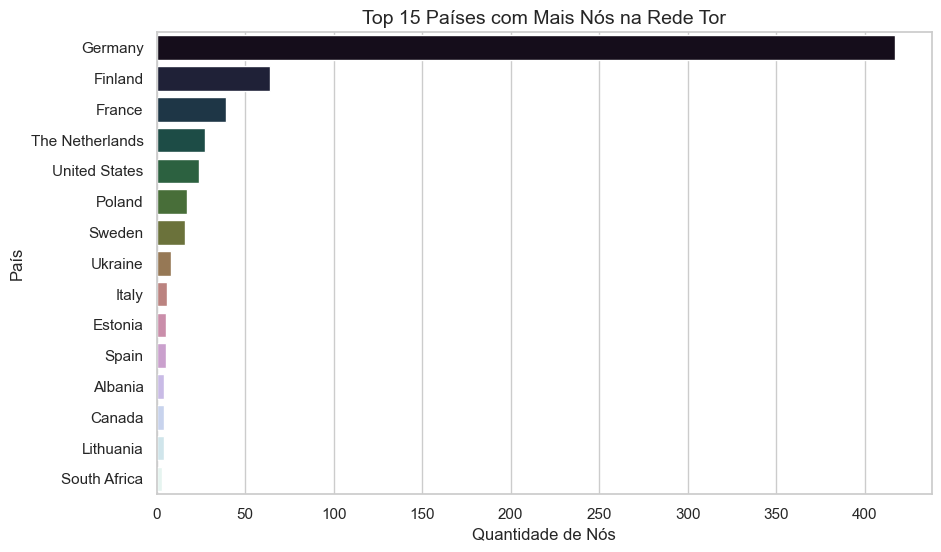

In [12]:
# 3.1 Distribuição Geral por País
country_counts = df_clean['country'].value_counts().head(15)

sns.barplot(y=country_counts.index, x=country_counts.values, palette="cubehelix")
plt.title("Top 15 Países com Mais Nós na Rede Tor")
plt.xlabel("Quantidade de Nós")
plt.ylabel("País")
plt.show()


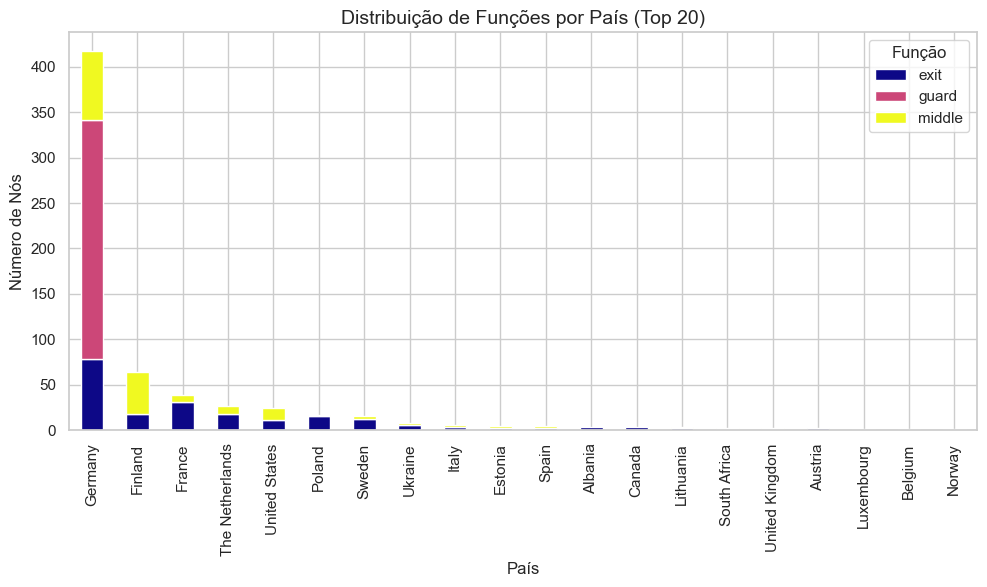

In [13]:
country_role_distribution = df_clean.groupby(['country', 'role']).size().unstack(fill_value=0)
top_20_countries = df_clean['country'].value_counts().head(20).index
country_role_top_20 = country_role_distribution.loc[top_20_countries]

country_role_top_20.plot(kind='bar', stacked=True, colormap='plasma')
plt.title("Distribuição de Funções por País (Top 20)")
plt.xlabel("País")
plt.ylabel("Número de Nós")
plt.legend(title="Função")
plt.tight_layout()
plt.show()


In [14]:
asn_role_top_20.to_csv('data_asn_por_funcao.csv')
country_role_top_20.to_csv('data_paises_por_funcao.csv')
country_counts.to_csv('data_paises_geral.csv')
print("Arquivos CSV exportados com sucesso!")


Arquivos CSV exportados com sucesso!
